# 1. Rectification

The template below first asks the user to upload three files: an image (`IMAGE`) and two point files (`SOURCE_POINTS_FILE` and `TARGET_POINTS_FILE`).
The point files must be in the form
```
    X1 Y1
    X2 Y2
    X3 Y3
    X4 Y4
```
to define four 2D points.

The `rectify()` below maps the image region defined by the four corners from `SOURCE_POINTS_FILE` to the new region defined by `TARGET_POINTS_FILE`, using the functions
* `build_A()`,
* `compute_H()`,
* `bilinear_interp()`, and
* `warp_homography()`.

Complete these functions in the code cells below, and run Step1-1 to Step1-4. These steps simply do
1. Upload an image file as `IMAGE`, (use "laptop.jpg" for testing)
2. Upload an text file as `SOURCE_POINTS_FILE`, (use "laptop_screen.txt" for testing)
3. Upload an text file as `TARGET_POINTS_FILE`, and (use "laptop_rect.txt" for testing)
4. Run `rectify()` and show the output image.


In [1]:
import numpy as np

def build_A(pts1, pts2):
    """Constructs the intermediate matrix A used in the computation of an
    homography mapping pts1 to pts2."""

    # Build and return A

    num_points = len(pts1)
    A = np.zeros((num_points * 2, 9))

    # every pair of points generates two equations

    for i in range(num_points):
      x1, y1 = pts1[i]
      x2, y2 = pts2[i]

      A[2 * i] = [x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 *y1, -x2]
      A[2 * i + 1] = [0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2]

    return A

In [2]:
def compute_H(pts1, pts2):
    """Computes an homography mapping one set of co-planar points (pts1) to another (pts2)."""

    # Construct the intermediate A matrix.
    A = build_A(pts1, pts2)
    # Compute the symmetric matrix AtA.
    AtA = A.T @ A
    # Compute the eigenvalues and eigenvectors of AtA.
    eigenvalues, eigenvectors = np.linalg.eig(AtA)
    # Return the eigenvector corresponding to the smallest eigenvalue, reshaped
    # as a 3x3 matrix.
    index = np.argmin(eigenvalues)
    H = eigenvectors[:, index]
    H = H.reshape(3, 3)

    return H


In [3]:
def bilinear_interp(image, points):
    """Looks up the pixel values in an image at a given point using bilinear
    interpolation."""
    # compute the length of x and y to avoid the accessing of points out of bounds
    y_len, x_len, channels = image.shape
    inter_values = np.zeros((points.shape[0], channels))

    # use for loops to compute the interploated value
    for i, (x, y) in enumerate(points):

      # compute the neareast four points in image
      x0, x1 = int(np.floor(x)), int((np.ceil(x)))
      y0, y1 = int(np.floor(y)), int((np.ceil(y)))

      # use np.clip to avoid the accessing of points out of bounds
      x0 = np.clip(x0, 0, x_len - 1)
      x1 = np.clip(x0, 0, x_len - 1)
      y0 = np.clip(y0, 0, y_len - 1)
      y1 = np.clip(y1, 0, y_len - 1)

      # compute the coefficients
      dx = x - x0
      dy = y - y0

      P1 = image[y0, x0]
      P2 = image[y1, x0]
      P3 = image[y0, x1]
      P4 = image[y1, x1]

      # using the coefficient to interplot
      inter_value = (
          P1 * (1 - dx) * (1 - dy) +
          P2 * (1 - dx) * dy +
          P3 * dx * (1 - dy) +
          P4 * dx * dy
          )

      inter_values[i] = inter_value

    # Return the result
    return inter_values

In [4]:
def warp_homography(source, target_shape, Hinv):
    """Warp the source image into the target coordinate frame using a provided
    inverse homography transformation."""

    # target_shape is the shape(minimum of x axis, maximum of y axis...) of transformed image
    # in Eucild coordinates.
    x_min, y_min, x_max, y_max = target_shape

    # use meshgrid to generate the coordinates of transformed image
    x_range, y_range = np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1)
    xx, yy = np.meshgrid(x_range, y_range)

    # use np.vstack to arrage each coordinate by row into a matrix
    coords = np.vstack([xx.ravel(), yy.ravel()])

    # append 1 to each coordinates so that it becomes homovector.
    ones = np.ones(len(xx.ravel()))
    coords = np.vstack([coords, ones])

    # compute the corresponding coordinates of each coordinate in the source image
    orig_coords = Hinv @ coords
    orig_coords = (orig_coords[0:2] / orig_coords[2]).T

    # use bilinear_interp to interplot and reshape the array returned
    tra_graph = bilinear_interp(source, orig_coords)
    tra_graph = tra_graph.reshape(y_max - y_min + 1, x_max - x_min + 1, 3)

    # Return the output image.
    return tra_graph

In [5]:
def rectify(image, planar_points, target_points):
    # Compute the rectifying homography that warps the planar points to the
    # target rectangular region.

    # compute the homograph transformation and its inverse
    H = compute_H(pts1, pts2)
    Hinv = compute_H(pts2, pts1)

    y_len, x_len, num_value = image.shape


    # Apply the rectifying homography to the bounding box of the planar image
    # to find its corresponding bounding box in the rectified space.

    # compute the four corners transformed
    corners = np.array([
        [0, 0, 1],
        [x_len, 0, 1],
        [0, y_len, 1],
        [x_len, y_len, 1]
    ]).T
    tra_corners = H @ corners
    tra_corners = tra_corners[0:2] / tra_corners[2]

    # compute the rectangular bounding box
    x_min, y_min = np.min(tra_corners, axis = 1).astype(int)
    x_max, y_max = np.max(tra_corners, axis = 1).astype(int)
    target_shape = (x_min, y_min, x_max, y_max)

    # Perform warping and return the result.
    return warp_homography(image, target_shape, Hinv)

In [6]:
# colaboratory-specific helper functions

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def upload_sub(msg):
    print(msg)
    f = files.upload()
    if bool(f) is False:
        return None
    fname = list(f.keys())[0]
    return fname

def upload(msg):
    f = None
    while f is None:
        f = upload_sub(msg)
    return f


## Step 1-1: Upload `IMAGE`

IMAGE:


Saving 499c2f351289882eb915fd8d957210c.jpg to 499c2f351289882eb915fd8d957210c (2).jpg


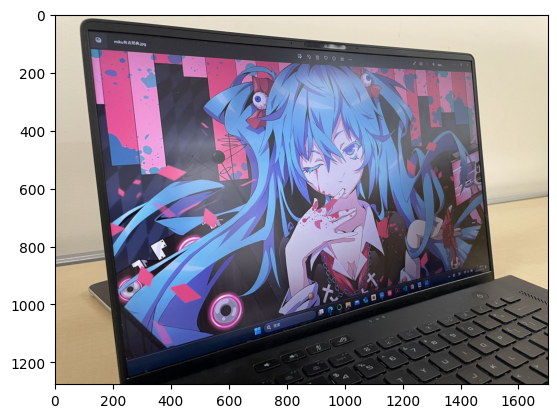

In [29]:
image = cv2.imread(upload('IMAGE:'), cv2.IMREAD_COLOR) # Use laptop.jpg for testing
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Step 1-2: Upload `SOURCE_POINTS_FILE`

In [30]:
pts1 = np.loadtxt(upload('SOURCE_POINTS_FILE:')) # Use laptop_screen.txt for testing
print(pts1)

SOURCE_POINTS_FILE:


Saving miku_screen.txt to miku_screen (3).txt
[[ 112.   52.]
 [1437.  165.]
 [1505.  890.]
 [ 249. 1260.]]


## Step 1-3:  TARGET_POINTS_FILE

In [33]:
pts2 = np.loadtxt(upload('TARGET_POINTS_FILE:')) # Use laptop_rect.txt for testing
print(pts2)

TARGET_POINTS_FILE:


Saving miku_rect.txt to miku_rect (1).txt
[[  0.   0.]
 [800.   0.]
 [800. 500.]
 [  0. 500.]]


## Step 1-4: Rectify

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

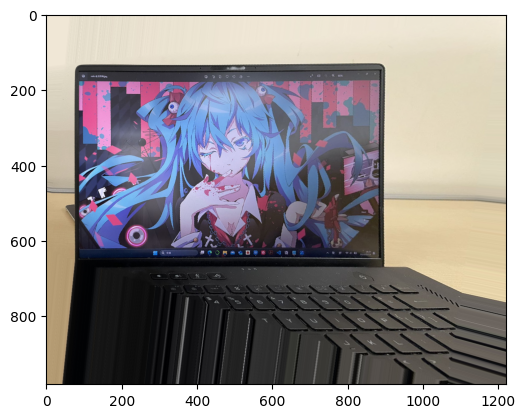

In [34]:
rectified = rectify(image, pts1, pts2).astype(np.uint8)

plt.imshow(cv2.cvtColor(rectified, cv2.COLOR_BGR2RGB))

# Just in case you want to download the output

cv2.imwrite("rectified.png", rectified)
files.download('rectified.png')

# 2. Composition

The function `composite()` below superimposes a region of a `source` image on top of a region of a `target` image. The source and the target regions are specified by corresponding points as done for `rectify()` above.

The function also takes a `mask` image which defines the transparency of `source`. This works as a stencil buffer if `mask` is a binary image, or as an alpha blending mask if grayscale.

In [8]:
def blend_with_mask(source, target, mask):
    """Blends the source image with the target image according to the mask.
    Pixels with value "1" are source pixels, "0" are target pixels, and
    intermediate values are interpolated linearly between the two."""
    blend_graph = mask * source + (1 - mask) * target
    blend_graph = np.clip(blend_graph, 0, 255).astype(np.uint8)

    return blend_graph

In [7]:
def bilinear_interp_one(image, point):
    # compute the length of x and y to avoid the accessing of points out of bounds
    y_len, x_len, channels = image.shape
    x, y = point
    # compute the neareast four points in image
    x0, x1 = int(np.floor(x)), int((np.ceil(x)))
    y0, y1 = int(np.floor(y)), int((np.ceil(y)))

    # use np.clip to avoid the accessing of points out of bounds
    x0 = np.clip(x0, 0, x_len - 1)
    x1 = np.clip(x0, 0, x_len - 1)
    y0 = np.clip(y0, 0, y_len - 1)
    y1 = np.clip(y1, 0, y_len - 1)

    # compute the coefficients
    dx = x - x0
    dy = y - y0

    P1 = image[y0, x0]
    P2 = image[y1, x0]
    P3 = image[y0, x1]
    P4 = image[y1, x1]

    # using the coefficient to interplot
    inter_value = (
        P1 * (1 - dx) * (1 - dy) +
        P2 * (1 - dx) * dy +
        P3 * dx * (1 - dy) +
        P4 * dx * dy
        )
    # Return the result
    return inter_value

In [9]:
def composite(source, target, source_pts, target_pts, mask):
    """Composites a masked planar region of the source image onto a
    corresponding planar region of the target image via homography warping."""

    # Compute the homography to warp points from the target to the source coordinate frame.
    H = compute_H(source_pts, target_pts)
    Hinv = compute_H(target_pts, source_pts)

    # Warp the images using the homography.
    # same as the warp function before
    y_len, x_len, num_channel = source.shape

    x_range, y_range = np.arange(0, x_len), np.arange(0, y_len)
    xx, yy = np.meshgrid(x_range, y_range)

    coords = np.vstack([xx.ravel(), yy.ravel()])

    ones = np.ones(len(xx.ravel()))
    coords = np.vstack([coords, ones])

    orig_coords = H @ coords
    orig_coords = (orig_coords[0:2] / orig_coords[2]).T

    warp_graph = bilinear_interp(target, orig_coords)
    warp_graph = warp_graph.reshape(y_len, x_len, num_channel)

    # Blend the warped images.
    blend_graph = blend_with_mask(source, warp_graph, mask)

    # same as the code in homography function before, just make some adjustments
    y_len_tar, x_len_tar, num_channel_tar = target.shape
    x_range_tar, y_range_tar = np.arange(0, x_len_tar), np.arange(0, y_len_tar)
    xx_tar, yy_tar = np.meshgrid(x_range_tar, y_range_tar)
    coords_tar = np.vstack([xx_tar.ravel(), yy_tar.ravel(), np.ones(len(xx_tar.ravel()))])


    trans_coords_tar = Hinv @ coords_tar
    trans_coords_tar = (trans_coords_tar[0:2] / trans_coords_tar[2]).T

    target = target.reshape(-1, num_channel_tar)
    print(target.shape)

    for i, (x, y) in enumerate(trans_coords_tar):
        if -1 < x < x_len and -1 < y < y_len:
          target[i, :] = bilinear_interp_one(blend_graph, (x, y))

    target = target.reshape(y_len_tar, x_len_tar, num_channel_tar)

    return target

## Step 2-1: Upload `SOURCE` image

SOURCE:


Saving sourcesource.jpg to sourcesource.jpg


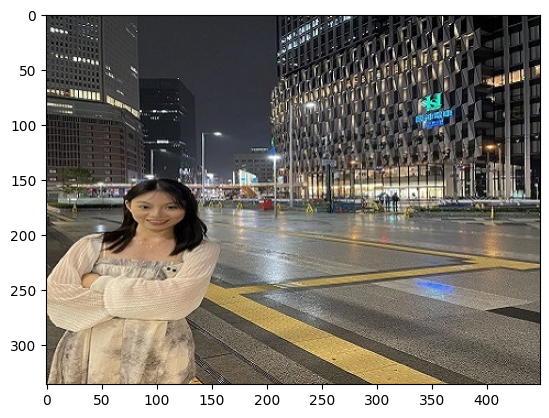

In [35]:
source = cv2.imread(upload('SOURCE:'), cv2.IMREAD_COLOR) # Use sourcesource.png for testing
plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))

## Step 2-2: Upload `TARGET` image

TARGET:


Saving 499c2f351289882eb915fd8d957210c.jpg to 499c2f351289882eb915fd8d957210c (1).jpg


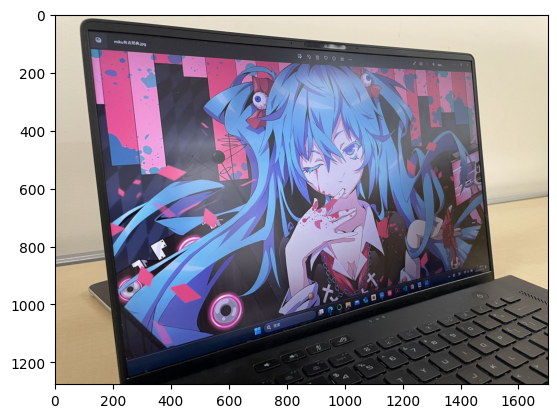

In [24]:
target = cv2.imread(upload('TARGET:'), cv2.IMREAD_COLOR) # Use laptop.jpg for testing
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

## Step 2-3: Upload `SOURCE_POINTS` file

In [25]:
source_pts = np.loadtxt(upload('SOURCE_POINTS_FILE:')) # Use panda_point.txt for testing
print(source_pts)

SOURCE_POINTS_FILE:


Saving panda_points.txt to panda_points (3).txt
[[  0.   0.]
 [448.   0.]
 [448. 335.]
 [  0. 335.]]


## Step 2-4: Upload `TARGET_POINTS` file

In [26]:
target_pts = np.loadtxt(upload('TARGET_POINTS_FILE:')) # Use miku_screen.txt for testing
print(target_pts)

TARGET_POINTS_FILE:


Saving miku_screen.txt to miku_screen (2).txt
[[ 112.   52.]
 [1437.  165.]
 [1505.  890.]
 [ 249. 1260.]]


## Step 2-5: Upload `MASK` image

MASK:


Saving panda_mask.png to panda_mask (2).png
(336, 449)


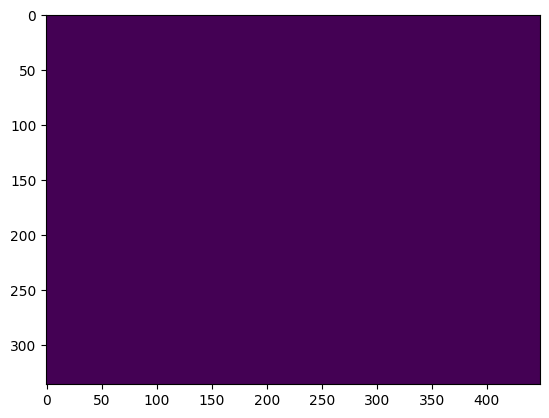

In [37]:
mask = cv2.imread(upload('MASK:'), cv2.IMREAD_GRAYSCALE) # Use panda_mask.png for testing
plt.imshow(mask)
print(mask.shape)

mask = mask[:, :, np.newaxis]

## Step 2-6: Composite

(2171752, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

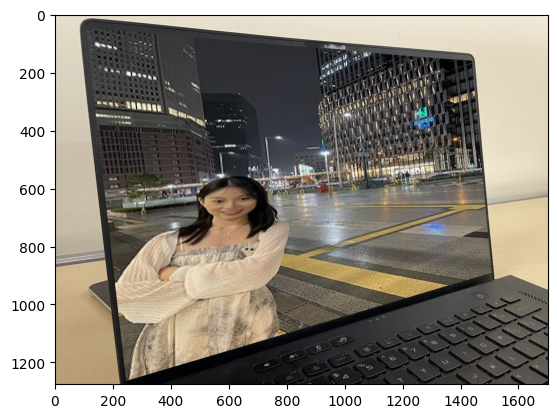

In [38]:
# The running time maybe one minute. just wait.....
composited = composite(source, target, source_pts, target_pts, mask/255.0).astype(np.uint8)
plt.imshow(cv2.cvtColor(composited, cv2.COLOR_BGR2RGB))

cv2.imwrite("composited.png", composited)
files.download('composited.png')